In [6]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import IPython.display as ipd

#import renamed libraries from the numerical toolbox
from local_signal import *
from general import *


In [7]:
def inpainting(image, p):
    """ 
    Given an image and a probability p, create a mask with p% of the pixels set to 0, and apply that mask to remove those pixels from the image.
    """
    mask = np.random.choice([0, 1], size=image.shape, p=[p, 1-p])
    return image * mask

def get_variance(snr, image, noise):
    """
    Function that computes the required variance of the noise to achieve a given SNR.
    """
    #get the norm of the image and the noise
    norm = np.linalg.norm(image)**2
    noise_norm = np.linalg.norm(noise)**2
    #compute the variance
    # variance = norm/(noise_norm*(np.exp((snr/10))))
    variance = norm/(noise_norm*(10**(snr/10)))
    return variance

def generate_noisy_image(snr, image):
    """ 
    Function that generates a noisy image with a given SNR.
    """
    noise = np.random.normal(0, 1, image.shape)
    variance = get_variance(snr, image, noise)
    sigma = np.sqrt(variance)
    noisy_image = image + noise * sigma
    return sigma, noisy_image

def compute_snr(image, noisy_image):
    """
    Function that computes the SNR between an image and a noisy image.
    """
    #get the norm of the image and the noise
    norm = np.linalg.norm(image)**2
    noise_norm = np.linalg.norm(noisy_image - image)**2
    #compute the SNR
    snr = 10*np.log10(norm/noise_norm)
    return snr

(512, 512)


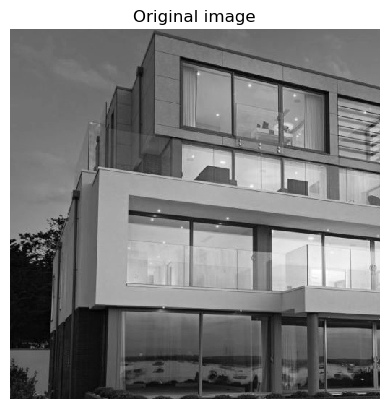

In [8]:
image = load_image('apartment.jpg')
#resize to 512x512
image = image[100:612, 100:612]
image_shape = image.shape
print(image.shape)

imageplot(image, "Original image")

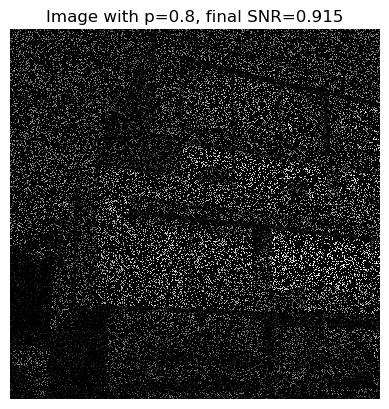

In [27]:
target_SNR = 13
noise_sigma, noisy_image = generate_noisy_image(target_SNR, image)
#imageplot(clamp(noisy_image), "Noisy, SNR=" + str(compute_snr(image, noisy_image)))

#perform inpainting with 0.7 probability
p = 0.8
inpainting_image = inpainting(noisy_image, p)
imageplot(clamp(inpainting_image), "Image with p=" + str(p) + ", final SNR=%.3f" %(compute_snr(image, inpainting_image)))

Text(0.5, 1.0, 'Thresholded coefficients')

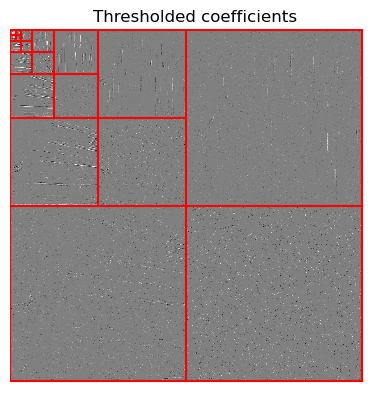

In [28]:
def thresh_soft(u,t):return np.maximum(1-t/abs(u), 0)*u
Jmin = 3
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
a = perform_wavortho_transf(noisy_image,Jmin,+1,h)
T = 3/2*noise_sigma
aT = thresh_soft(a,T)
plot_wavelet(aT,Jmin);
plt.title("Thresholded coefficients")


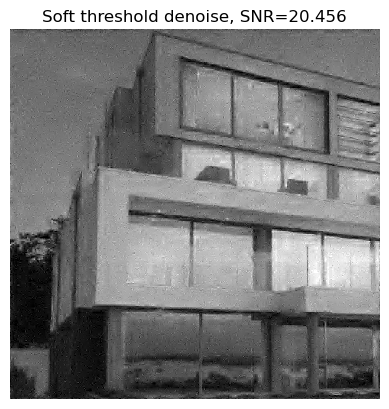

In [29]:
fHard = perform_wavortho_transf(aT,Jmin,-1,h)
imageplot(clamp(fHard), 'Soft threshold denoise, SNR=%.3f' %(snr(image,fHard)) )